## Baseline Model

A baseline model is a trivial solution to our problem. The baseline model is the simplest solution you can think of—it should not require any training, and the cost of implementation should be very low. 

In the context of time series forecasting, the three most common types of baseline models are:
1. ***Arithematic mean***: compute the mean of the values over a certain period and assume that future values will be equal to that mean.
2. ***Forecast the last recorded point***
3. ***Cyclic pattern***:  if we see a cyclical pattern in our data, we can repeat that pattern in the future.

## About the dataset

We are going to work with the quarterly EPS in US dollars (USD) of Johnson & Johnson from 1960 to 1980. Our goal is to use the data from 1960 to the end of 1979 to predict the four quarters of 1980.

In [1]:
import pandas as pd

df = pd.read_csv('datasets/quarterly_eps_data.csv')
df = df.drop(['Unnamed: 0', 'X'], axis=1)
df.head()

,time,value
0,1960.00,0.71
1,1960.25,0.63
2,1960.50,0.85
3,1960.75,0.44
4,1961.00,0.61


In [2]:
df.tail()

,time,value
79,1979.75,9.99
80,1980.00,16.20
81,1980.25,14.67
82,1980.50,16.02
83,1980.75,11.61


In [3]:
# Define a function to convert
def convert_quarterly_to_date(val):
    year = int(val)  # Extract the year
    quarter = val - year  # Extract the decimal part

    # Map the decimal part to the corresponding month
    if quarter == 0.00:
        month = 1  # January (Q1)
    elif quarter == 0.25:
        month = 4  # April (Q2)
    elif quarter == 0.50:
        month = 7  # July (Q3)
    elif quarter == 0.75:
        month = 10  # October (Q4)
    
    return pd.Timestamp(year=year, month=month, day=1)

In [4]:
# Apply the function to the 'quarterly' column
df['date'] = df['time'].apply(convert_quarterly_to_date)
df = df[['date', 'value']]
df.head()

,date,value
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-01,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


<Axes: xlabel='date', ylabel='value'>

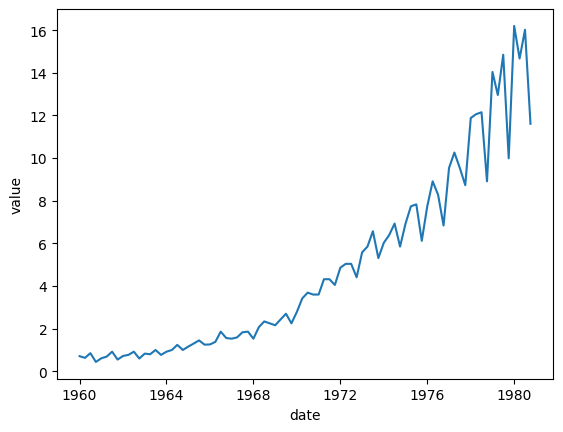

In [5]:
import seaborn as sns

sns.lineplot(data=df, x="date", y="value")

In [6]:
# Split the data into train and test set
train = df[:-4]
test = df[-4:]

## 1. Historical mean baseline

In [7]:
# Compute mean of the value column
import numpy as np

historic_mean = np.mean(train['value'])
print(historic_mean)

4.3085


In [8]:
test.loc[:,'pred_mean'] = historic_mean
test

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_4356\4113295646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_mean'] = historic_mean


,date,value,pred_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-01,16.02,4.3085
83,1980-10-01,11.61,4.3085


In [9]:
# A function to evaluate the model
# Calculates mean absolute percentage error (MAPE)

def mape(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)/y_true)*100

In [10]:
mape_hist_mean = mape(test['value'], test['pred_mean'])
mape_hist_mean

np.float64(70.00752571263575)

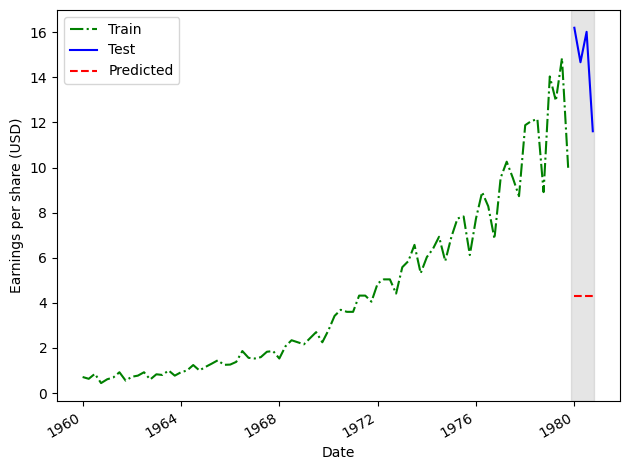

In [11]:
# Visualising the model
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(train['date'], train['value'], 'g-.', label='Train')
ax.plot(test['date'], test['value'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(3600, 3950, color='#808080', alpha=0.2)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### Predicting last years mean

In [12]:
last_year_mean = np.mean(train.value[-4:])
print(last_year_mean)

12.96


In [13]:
test.loc[:,'last_year_mean'] = last_year_mean
test

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_4356\928121615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'last_year_mean'] = last_year_mean


,date,value,pred_mean,last_year_mean
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-01,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


In [14]:
mape_last_year_mean = mape(test['value'], test['last_year_mean'])
mape_last_year_mean

np.float64(15.5963680725103)

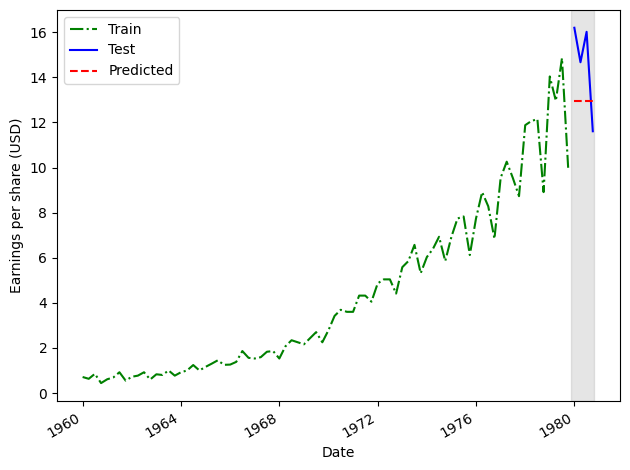

In [15]:
fig, ax = plt.subplots()
ax.plot(train['date'], train['value'], 'g-.', label='Train')
ax.plot(test['date'], test['value'], 'b-', label='Test')
ax.plot(test['date'], test['last_year_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(3600, 3950, color='#808080', alpha=0.2)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

## 2. Prediction using the last known value

In [16]:
last_value = train['value'].iloc[-1]
last_value

np.float64(9.99)

In [17]:
test.loc[:,'pred_last'] = last_value
test

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_4356\2905813924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_last'] = last_value


,date,value,pred_mean,last_year_mean,pred_last
80,1980-01-01,16.20,4.3085,12.96,9.99
81,1980-04-01,14.67,4.3085,12.96,9.99
82,1980-07-01,16.02,4.3085,12.96,9.99
83,1980-10-01,11.61,4.3085,12.96,9.99


In [18]:
mape_last = mape(test['value'], test['pred_last'])
print(mape_last)

30.457277908606535


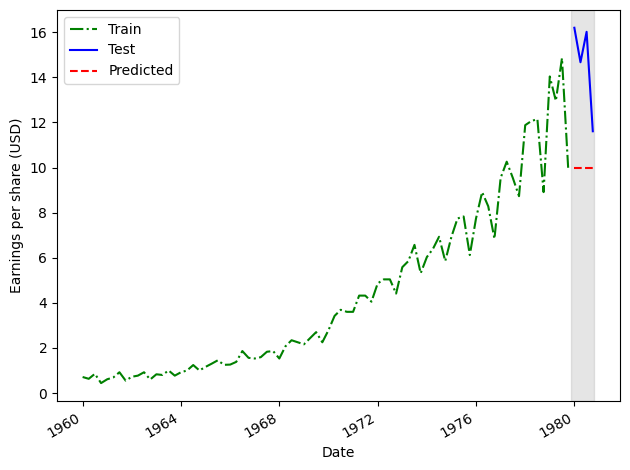

In [19]:
fig, ax = plt.subplots()
ax.plot(train['date'], train['value'], 'g-.', label='Train')
ax.plot(test['date'], test['value'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(3600, 3950, color='#808080', alpha=0.2)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

## 3. Seasonal baseline

In [20]:
test.loc[:,'last_season'] = train['value'].iloc[-4:].values
test

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_4356\505040911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'last_season'] = train['value'].iloc[-4:].values


,date,value,pred_mean,last_year_mean,pred_last,last_season
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-01,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [21]:
mape_last_season = mape(test['value'], test['last_season'])
print(mape_last_season)

11.561658552433654


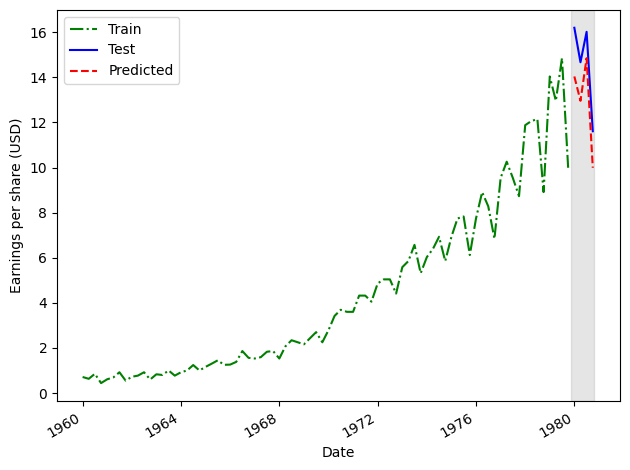

In [22]:
fig, ax = plt.subplots()
ax.plot(train['date'], train['value'], 'g-.', label='Train')
ax.plot(test['date'], test['value'], 'b-', label='Test')
ax.plot(test['date'], test['last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(3600, 3950, color='#808080', alpha=0.2)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

## Comparing the baseline models

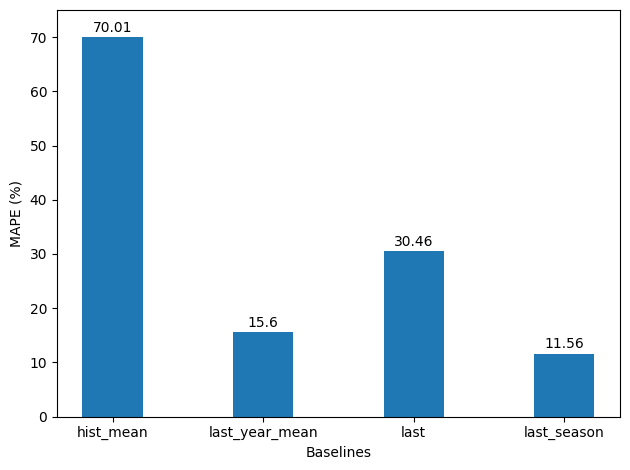

In [23]:
fig, ax = plt.subplots()

x = ['hist_mean', 'last_year_mean', 'last', 'last_season']
y = [70.01, 15.60, 30.46, 11.56]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 75)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(value), ha='center')

plt.tight_layout()